# Put Fe K cross-section from Rogantini into ISMdust

http://adsabs.harvard.edu/abs/2017arXiv170905359R

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from astropy.table import Table
import astropy.units as u
import astropy.constants as c

from minerals import Mineral
import abundances
import VY1995

In [3]:
# values come from FeK_Rogantini/tabs_CDS/ReadMe.txt
olivine = Mineral({'Mg':1.56, 'Fe':0.4, 'Si':0.91, 'O':4}, name='Olivine') # I'm not sure if I'm reading this right

In [4]:
dust_mass_ratio = 0.01 # dust to gas mass ratio
NH = 1.e22 * u.Unit('cm^-2')
MD = NH * c.m_p.to('g') * dust_mass_ratio

In [5]:
olivine_xsect = Table.read('FeK_Rogantini/tabs_CDS/sample/olivine.dat', format='ascii', header_start=2, data_start=3)

In [6]:
olivine_xsect.colnames

['energy', 'extinction', 'scattering', 'absorption']

In [7]:
def FeK_xsect(keyword, tbl):
    assert keyword in olivine_xsect.colnames[1:]
    energy = olivine_xsect['energy'] * u.keV
    result = olivine_xsect[keyword] * u.Unit('cm^2')
    return energy, result

In [8]:
ener, exti = FeK_xsect('extinction', olivine_xsect)
_, scat = FeK_xsect('scattering', olivine_xsect)
_, abso = FeK_xsect('absorption', olivine_xsect)

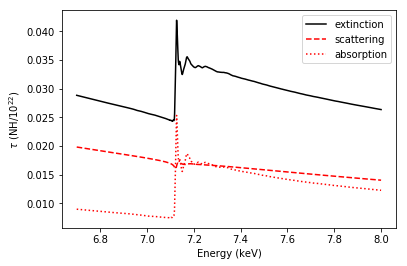

In [9]:
plt.plot(ener, exti * NH, color='k', label='extinction')
plt.plot(ener, scat * NH, color='r', ls='--', label='scattering')
plt.plot(ener, abso * NH, color='r', ls=':', label='absorption')
plt.xlabel('Energy ({})'.format(ener.unit))
plt.ylabel(r'$\tau$ (NH/10$^{22}$)')
plt.legend(loc='upper right')

## Compare this to ISMdust

In [10]:
import os
from astropy.io import fits

ismdust_sil_filename = os.environ['ISMDUSTROOT'] + 'edge_files/silicate_xs.fits'

In [11]:
ismdust_sil = fits.open(ismdust_sil_filename)

In [12]:
## Note the parameters that were used to produce the ISMdust model
ismdust_sil[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
AMIN    = '0.005   '                                                            
AMAX    = '0.300   '                                                            
P       = '3.500   '                                                            
RHO     = '3.800   '                                                            
MDUST   = '1.00e-04'                                                            
GTYPE   = 'Silicate'                                                            
COMMENT Created by liac@umich.edu on 2018-06-25                                 

In [13]:
ismdust_sil[1].data.columns

ColDefs(
    name = 'energy'; format = 'E'
    name = 'angstroms'; format = 'E'
    name = 'ext'; format = 'E'
    name = 'sca'; format = 'E'
    name = 'abs'; format = 'E'
)

In [14]:
def sil_xsect(keyword, fitsfile):
    fits_tbl = fitsfile[1].data
    mdust = np.float(fitsfile[0].header['MDUST']) * u.Unit('g cm^-2')
    assert keyword in fits_tbl.columns.names[2:]
    energy = fits_tbl['energy'] * u.keV
    result = fits_tbl[keyword] / mdust
    return energy, result.to(u.Unit('g^-1 cm^2'))

In [15]:
ener2, exti2 = sil_xsect('ext', ismdust_sil)
_, scat2 = sil_xsect('sca', ismdust_sil)
_, abso2 = sil_xsect('abs', ismdust_sil)

(0, 0.08)

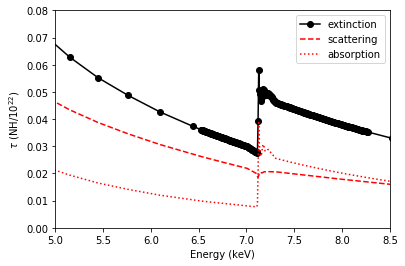

In [16]:
## One can see that ISMdust was not calculated at high resolution in this region
## Mainly because the target was gratings data, which has evenly spaced resolution in angstrom
plt.plot(ener2, exti2 * MD, color='k', marker='o', label='extinction')
plt.plot(ener2, scat2 * MD, color='r', ls='--', label='scattering')
plt.plot(ener2, abso2 * MD, color='r', ls=':', label='absorption')
plt.xlabel('Energy ({})'.format(ener.unit))
plt.ylabel(r'$\tau$ (NH/10$^{22}$)')
plt.legend(loc='upper right')
plt.xlim(5.0, 8.5)
plt.ylim(0, 0.08)

# Compare extinction and absorption from all models

## 1. Extinction

Text(0,0.5,'Extinction $\\tau$ (NH/10$^{22}$)')

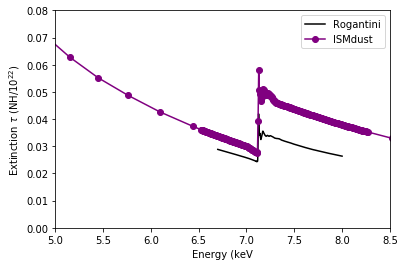

In [17]:
plt.plot(ener, exti * NH, color='k', label='Rogantini')
plt.plot(ener2, exti2 * MD, color='purple', marker='o', label='ISMdust')
plt.xlim(5.0, 8.5)
plt.ylim(0, 0.08)
plt.legend(loc='upper right')
plt.xlabel('Energy ({}'.format(ener.unit))
plt.ylabel(r'Extinction $\tau$ (NH/10$^{22}$)')
#plt.savefig('compare_extinction.pdf', format='pdf')

## 2. Absorption

Also compare with expecations from Verner & Yaklovev (1995) absorption

In [18]:
# mass of olivine unit cell
olivine_unit_mass = sum([olivine.number(ele) * abundances.amu[ele] * c.u.to('g') for ele in olivine.elements])

# number of olivine unit cells per NH=1e22 column density
olivine_dens = MD / olivine_unit_mass

In [19]:
# calculate cross-section component (area) from each element in olivine
xsects = {ele:VY1995.compute_xsect(ener2, abundances.Z[ele], 0) * olivine.number(ele)
          for ele in olivine.elements}

# sum to obtain the cross-section per unit cel
total_xsect = np.zeros(len(ener2)) * u.Unit('cm^2')
for ele in xsects.keys():
    total_xsect += xsects[ele].to('cm^2')

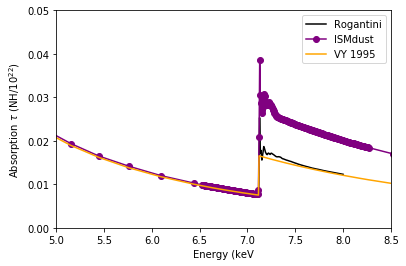

In [20]:
plt.plot(ener, abso * NH, color='k', label='Rogantini')
plt.plot(ener2, abso2 * MD, color='purple', marker='o', label='ISMdust')
plt.plot(ener2, total_xsect * olivine_dens, color='orange', label='VY 1995')
plt.xlim(5.0, 8.5)
plt.ylim(0, 0.05)
plt.legend(loc='upper right')
plt.xlabel('Energy ({}'.format(ener.unit))
plt.ylabel(r'Absorption $\tau$ (NH/10$^{22}$)')
plt.savefig('compare_absorption.pdf', format='pdf')

### Piece together an ISM absorption cross-section

In [22]:
# Making a function out of the above
# does not take dust grain shielding into account (see Wilms 2000)
def calculate_pure_absorption(energy, mineral, md=MD):
    unit_mass = sum([mineral.number(ele) * abundances.amu[ele] * c.u.to('g')
                     for ele in mineral.elements])
    number_dens = md / unit_mass
    xsects = {ele:VY1995.compute_xsect(energy, abundances.Z[ele], 0) * mineral.number(ele)
              for ele in mineral.elements}
    result = np.zeros(len(energy)) * u.Unit('cm^2')
    for ele in mineral.elements:
        result += xsects[ele].to('cm^2')
    return result

In [23]:
# Make a final energy grid
new_abs_ener = np.append(np.append(np.append(
    ener2[ener2 < ener[0]].value, 
    ener.value), 
    ener2[ener2 > ener[-1]].value), 
    np.arange(ener2[-1].value + 0.1, 300.01, 0.1)) * u.keV

# mask for energy values used in Rogantini cross-section
rog_eners = (new_abs_ener >= ener[0]) & (new_abs_ener <= ener[-1])

In [ ]:
# Evaluate VY 1995 on that grid
vy95_abs = calculate_pure_absorption(new_abs_ener, olivine, md=MD)

In [ ]:
plt.plot(ener2, abso2 * MD, color='purple', label='ISMdust')
plt.plot(new_abs_ener, vy95_abs * olivine_dens, color='orange', label='VY 1995 olivine mix')
plt.loglog()
plt.xlabel('Energy ({})'.format(new_abs_ener.unit))
plt.ylabel(r'Absorption $\tau$ (NH/10$^{22}$)')
plt.legend(loc='lower left')

In [ ]:
plt.plot(new_abs_ener[rog_eners], vy95_abs[rog_eners] * olivine_dens, color='orange', label='VY 1995 olivine mix')
plt.plot(ener, abso * NH, color='k', label='Rogantini olivine')
plt.xlabel('Energy ({})'.format(new_abs_ener.unit))
plt.ylabel(r'Absorption $\tau$ (NH/10$^{22}$)')
plt.legend(loc='upper right')

Rescale the Rogantini cross-section to match VY 1995 on the left and right side

In [ ]:
case_a_vy  = (vy95_abs[rog_eners][-1] - vy95_abs[rog_eners][0]) * olivine_dens
case_a_rog = (abso[-1] - abso[0]) * NH
abso_rescale = ((abso - abso[0]) * (case_a_vy/case_a_rog) * NH + vy95_abs[rog_eners][0] * olivine_dens) / NH

In [ ]:
# Just to get a sense of the re-scale
case_a_vy/case_a_rog

In [ ]:
ener[1:] - ener[:-1]

In [ ]:
ener[0], ener[-1]

In [ ]:
12.4/6.7, 12.4/8.0

In [ ]:
plt.plot(ener, abso_rescale * NH, color='k', label='Rogantini olivine rescaled')
plt.plot(new_abs_ener[rog_eners], vy95_abs[rog_eners] * olivine_dens, 
         color='orange', ls='--', label='VY 1995 olivine mix')
plt.xlabel('Energy ({})'.format(new_abs_ener.unit))
plt.ylabel(r'Absorption $\tau$ (NH/10$^{22}$)')
plt.legend(loc='upper right')

Now rescale ISMdust to the low-energy side of VY 1995, and insert the scaled Rogantini cross-section

In [ ]:
from scipy.interpolate import interp1d

In [ ]:
vy95_abs_interp = interp1d(new_abs_ener.value, vy95_abs.value)

In [ ]:
temp_region = (ener2.value < ener[0].value)
ismdust_rescale = abso2[temp_region][-1] * MD - \
    vy95_abs_interp(ener2[temp_region][-1].to('keV').value) * u.Unit('cm^2') * olivine_dens

In [ ]:
print(abso2[temp_region][-1], ismdust_rescale / MD)

So, I'll be rescaling the absorption component of ISMdust by 2%

In [ ]:
new_ismdust_abs = abso2 - ismdust_rescale/MD

In [ ]:
plt.plot(ener, abso_rescale * NH, color='k', label='Rogantini olivine rescaled')
plt.plot(new_abs_ener, vy95_abs * olivine_dens, 
         color='orange', ls='--', label='VY 1995 olivine mix')
plt.plot(ener2, new_ismdust_abs * MD, 
         color='purple', ls='--', label='ISMdust rescaled')
plt.xlabel('Energy ({})'.format(new_abs_ener.unit))
plt.ylabel(r'Absorption $\tau$ (NH/10$^{22}$)')
plt.legend(loc='upper left')
plt.xlim(5.0, 8.5)
plt.ylim(0.007, 0.03)

In [ ]:
new_abs = np.append(np.append(new_ismdust_abs[temp_region] * MD, abso_rescale * NH), 
                    vy95_abs[new_abs_ener > ener[-1]] * olivine_dens) / MD

In [ ]:
plt.plot(new_abs_ener, new_abs * MD, color='k', lw=3, label='Final Version')
plt.plot(new_abs_ener, vy95_abs * olivine_dens, 
         color='orange', ls='--', label='VY 1995 olivine mix')
plt.plot(ener2, new_ismdust_abs * MD, 
         color='purple', ls='--', label='ISMdust rescaled')
plt.xlabel('Energy ({})'.format(new_abs_ener.unit))
plt.ylabel(r'Absorption $\tau$ (NH/10$^{22}$)')
plt.legend(loc='upper left')
plt.xlim(5.0, 8.5)
plt.ylim(0.007, 0.03)
plt.savefig('ismdust_olivine_FeK.pdf', format='pdf')

In [ ]:
plt.plot(new_abs_ener, new_abs * MD, color='k', lw=3, label='Final Version')
plt.plot(new_abs_ener, vy95_abs * olivine_dens, 
         color='orange', ls='--', label='VY 1995 olivine mix')
plt.plot(ener2, new_ismdust_abs * MD, 
         color='purple', ls='--', label='ISMdust rescaled')
plt.xlabel('Energy ({})'.format(new_abs_ener.unit))
plt.ylabel(r'Absorption $\tau$ (NH/10$^{22}$)')
plt.legend(loc='lower left')
plt.loglog()
plt.savefig('ismdust_olivine.pdf', format='pdf')

### Write the new absorption cross-section to a file

In [ ]:
import datetime

In [ ]:
MODEL_MDUST = 1.e-4 * u.Unit('g cm^-2')

In [ ]:
def make_abs_fits(energy, xsect_abs, filename, md=MODEL_MDUST, clobber=True):    
    col1 = fits.Column(name='energy', format='E', array=energy.to('eV').value)
    col2 = fits.Column(name='angstroms', format='E', array=energy.to('angstrom', equivalencies=u.spectral()).value)
    col3 = fits.Column(name='abs', format='E', array=xsect_abs.to('').value)
    
    cols  = fits.ColDefs([col1,col2,col3])
    tbhdu = fits.BinTableHDU.from_columns(cols)
    #tbhdu.writeto(filename)
    
    prihdr = fits.Header()
    prihdr['MDUST']   = "{:.3e}".format(md.value)
    prihdr['COMMENT'] = "Created by %s on %s" % ("lia@astro.wisc.edu", datetime.date.today())
    prihdu = fits.PrimaryHDU(header=prihdr)
    
    thdulist = fits.HDUList([prihdu, tbhdu])
    thdulist.writeto(filename, overwrite=clobber)
    return

In [ ]:
make_abs_fits(new_abs_ener, new_abs * MODEL_MDUST, "ismdust_olivine_abs.fits")

### Test that the fits file works properly

In [ ]:
test = fits.open("ismdust_olivine_abs.fits")

In [ ]:
test[0].header

In [ ]:
test[1].data.columns

In [ ]:
etest, abstest = test[1].data['energy'] * u.eV, test[1].data['abs']
plt.plot(etest, abstest)
plt.plot(new_abs_ener.to('eV'), new_abs * MODEL_MDUST.value, ls='--')
plt.loglog()
#plt.axvline(1.e3)
#plt.axhline(0.4)

In [ ]:
wtest, abstest = test[1].data['angstroms'], test[1].data['abs']
plt.plot(wtest, abstest)
plt.plot(new_abs_ener.to(u.angstrom, equivalencies=u.spectral()), new_abs  * MODEL_MDUST.value, ls='--')
plt.loglog()

In [ ]:
len(new_abs_ener), len(wtest)